In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import seaborn as sns

# Import the sleap_roots package
import sleap_roots as sr

from pathlib import Path

# Use the following notation to import individual functions from the sleap_roots package
from sleap_roots.points import get_all_pts_array
from sleap_roots.convhull import get_convhull, get_chull_area, get_chull_perimeter
from sleap_roots.lengths import get_root_lengths, get_curve_index
from sleap_roots.bases import get_bases, get_base_tip_dist
from sleap_roots.tips import get_tips

In [3]:
# Print sleap_roots version
print(sr.__version__)

0.0.7


In [4]:
# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current directory:", current_directory)

Current directory: c:\repos\sleap-roots\notebooks


In [5]:
# Use this cell if you want to change the current working directory

# Define the directory you want to change to
new_directory = "C:/repos/sleap-roots"

# Change the current working directory
os.chdir(new_directory)

# Get the updated current working directory
updated_directory = os.getcwd()

# Print the updated current working directory
print("Updated current directory:", updated_directory)


Updated current directory: C:\repos\sleap-roots


In [7]:
# Change these variables for your own data
folder_path = "tests/data/rice_10do" # Location of h5 files and predictions for older monocots
crown_name = "crown" # For loading crown root predictions

In [8]:
# Find all h5 files in the folder
all_h5s = sr.find_all_series(folder_path)
all_h5s

['tests/data/rice_10do/0K9E8BI.h5']

In [9]:
# Load the cylinder series (one per h5 file)
all_series = [sr.Series.load(h5_path=h5, crown_name=crown_name) for h5 in all_h5s]
all_series

[Series(h5_path='tests/data/rice_10do/0K9E8BI.h5', primary_labels=None, lateral_labels=None, crown_labels=Labels(labeled_frames=72, videos=1, skeletons=1, tracks=0), video=Video(filename="tests/data/rice_10do/0K9E8BI.h5", shape=(72, 1080, 2048, 1), dataset=vol, backend=HDF5Video), csv_path=None)]

Example usage for one sample

In [10]:
# Get the first series in the list
series = all_series[0]
print(f"First sample has name {series.series_name}")
print(f"First sample video info: {series.video}")

First sample has name 0K9E8BI
First sample video info: Video(filename="tests/data/rice_10do/0K9E8BI.h5", shape=(72, 1080, 2048, 1), dataset=vol, backend=HDF5Video)


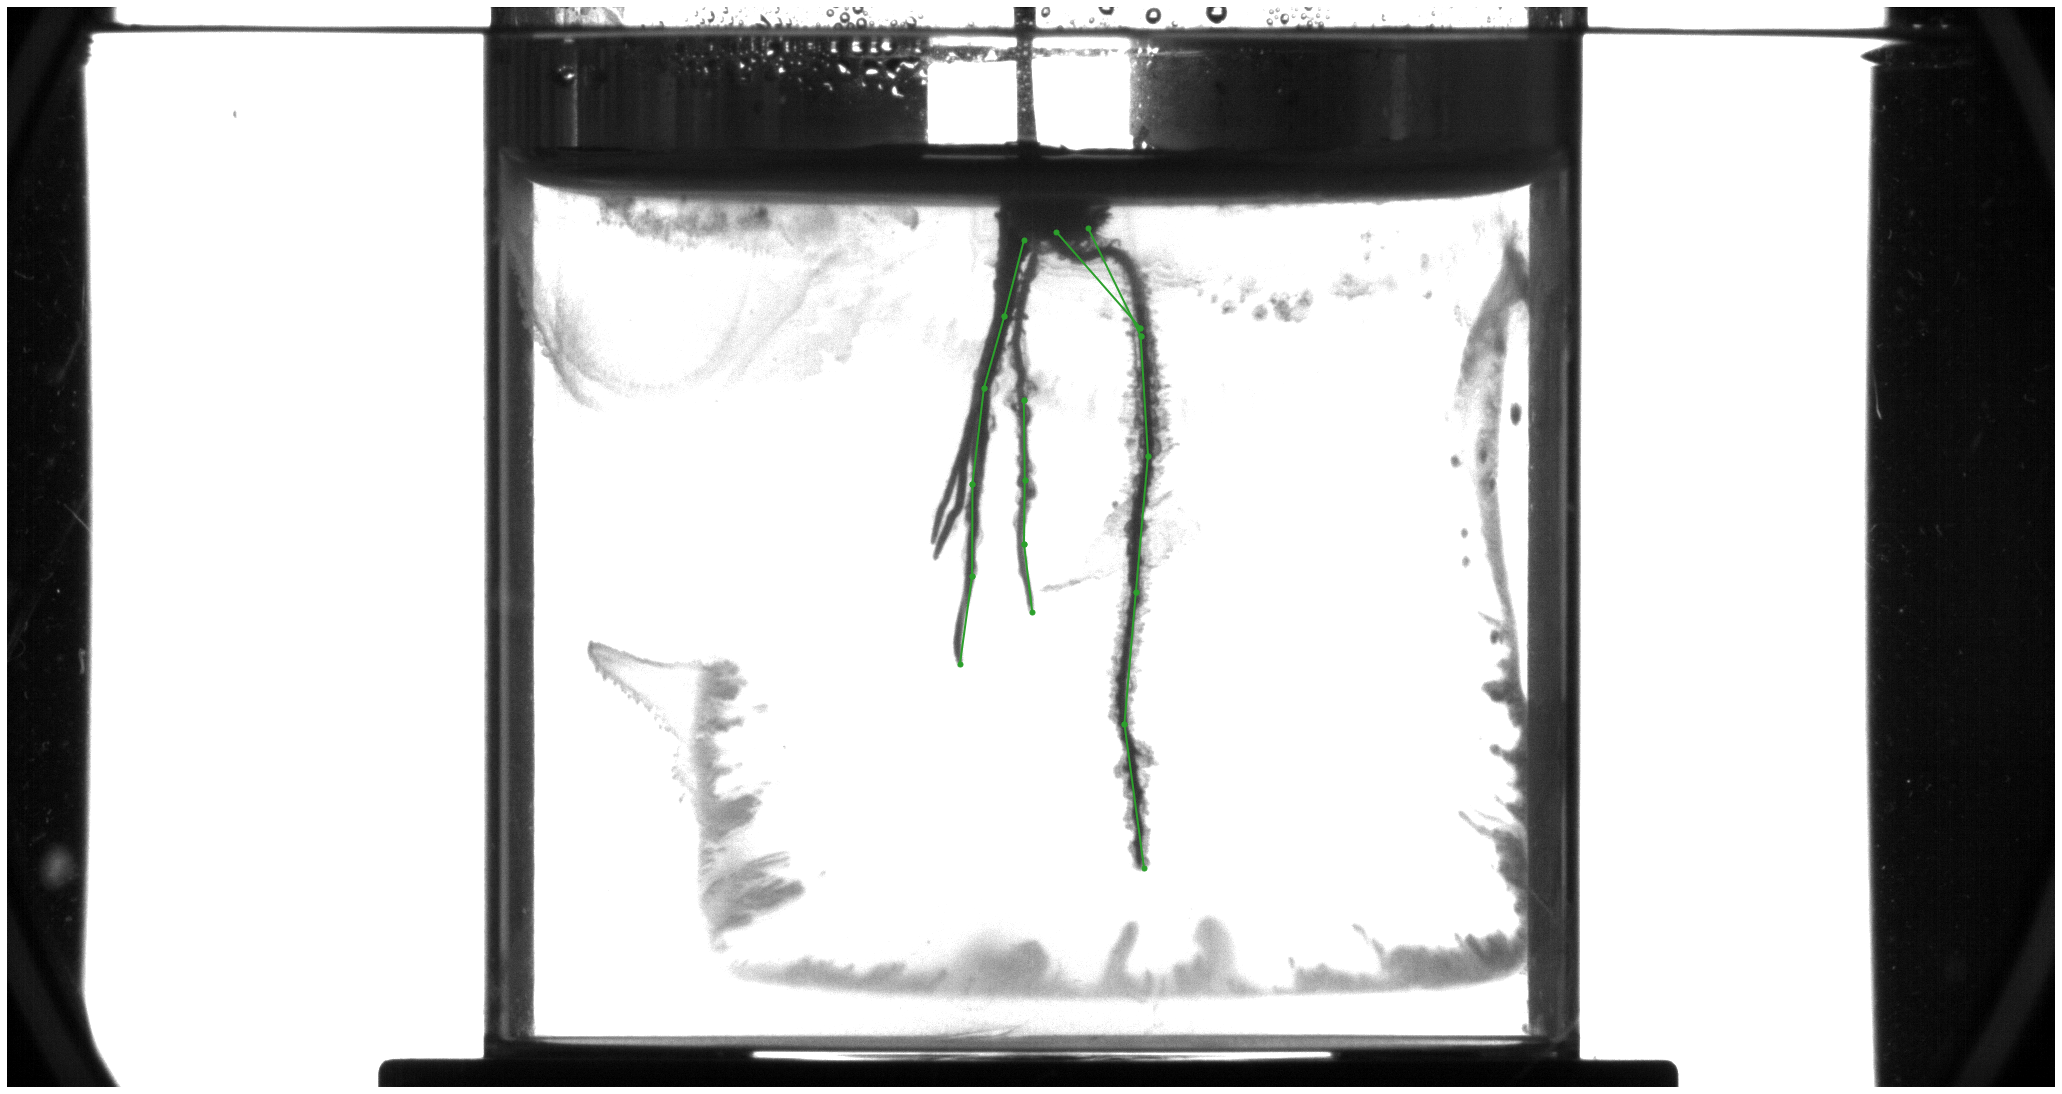

In [11]:
# Plot the first frame of the first series
series.plot(0)

In [13]:
# Get the crown root points for the first frame
crown_pts = series.get_crown_points(0)
print(f"Shape of crown points: {crown_pts.shape}")

Shape of crown points: (4, 6, 2)


In [14]:
# Get crown root lengths for the first frame
crown_lengths = get_root_lengths(crown_pts)
print(f"crown root lengths shape is {crown_lengths.shape}")

crown root lengths shape is (4,)


In [16]:
# Get base point of the crown roots
crown_bases = get_bases(crown_pts)

# Get tip point of the crown roots
crown_tips = get_tips(crown_pts)

# Get the distance between the base and tip of the crown roots
base_tip_dists = get_base_tip_dist(crown_bases, crown_tips)
print(f"Average base to tip distance is {np.nanmean(base_tip_dists)} px")

# Get the curve index (measure of curvature between 0 and 1) of the crown roots
curve_indices = get_curve_index(crown_lengths, base_tip_dists)
print(f"Average curve index of crown roots is {np.nanmean(curve_indices)}")

Average base to tip distance is 535.7640120955366 px
Average curve index of crown roots is 0.011777935773599708


In [18]:
# Aggregate the crown points in one flattened array
all_pts = get_all_pts_array(crown_pts)
print(f"Shape of all points: {all_pts.shape}")

# Get the convex hull of the crown points
convhull = get_convhull(all_pts)

# Get the area of the convex hull
chull_area = get_chull_area(convhull)
print(f"Area of convex hull is {chull_area} px^2")

# Get the perimeter of the convex hull
chull_perimeter = get_chull_perimeter(convhull)
print(f"Perimeter of convex hull is {chull_perimeter} px")

Shape of all points: (24, 2)
Area of convex hull is 86421.99331837709 px^2
Perimeter of convex hull is 1423.6432096235853 px


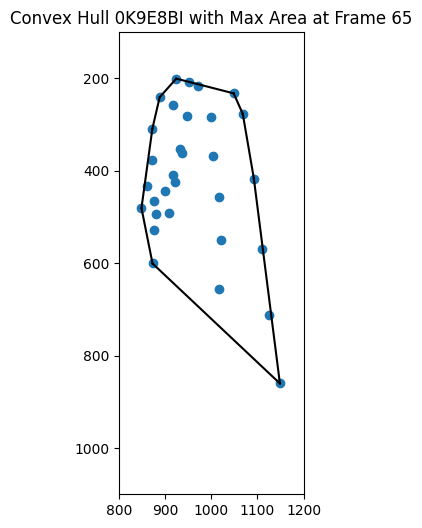

In [22]:
# Find the frame with the largest convex hull area and plot it

# Initialize lists to store the convex hull areas
hull, area = [], []

# Run convex hull features on all frames for crown roots
for i in range(len(series)):
    # Get crown root points
    crown_pts = series.get_crown_points(i)
    # Aggregate the crown points in one flattened array
    all_pts = get_all_pts_array(crown_pts)

    # Get the convex hull of the crown points
    convhull = get_convhull(all_pts)
    # Get the area of the convex hull
    chull_area = get_chull_area(convhull)

    # Append the convex hull and convex hull area to the lists
    hull.append(convhull)
    area.append(chull_area)

    
# Frame with the max convex hull area
idx_max_area = np.nanargmax(area)

# Plot convex hull of frame with the max width
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(hull[idx_max_area].points[:,0], hull[idx_max_area].points[:,1], 'o')
for simplex in hull[idx_max_area].simplices:
    ax.plot(hull[idx_max_area].points[simplex, 0], hull[idx_max_area].points[simplex, 1], 'k-')

plt.title(f"Convex Hull {series.series_name} with Max Area at Frame {idx_max_area}")    
plt.xlim([800, 1200])
plt.ylim([1100, 100]) # Invert y-axis to match image coordinates
ax.set_aspect('equal')  # Set aspect ratio to 1
plt.show()



Use the `OlderMonocotPipeline` to calculate all traits

In [23]:
# Initialize the pipeline
pipeline = sr.OlderMonocotPipeline()

In [24]:
# Compute the traits for one plant
plant_traits_df = pipeline.compute_plant_traits(series, write_csv=True)

In [25]:
# Display the plant traits
plant_traits_df

,plant_name,frame_idx,crown_count,crown_lengths_min,crown_lengths_max,crown_lengths_mean,crown_lengths_median,crown_lengths_std,crown_lengths_p5,crown_lengths_p25,...,chull_line_lengths_p25,chull_line_lengths_p75,chull_line_lengths_p95,ellipse_ratio,scanline_last_ind,scanline_first_ind,angle_chull_r1_left_intersection_vector,angle_chull_r1_right_intersection_vector,chull_area_above_r1_intersection,chull_area_below_r1_intersection
0,0K9E8BI,0,4,127.788895,654.761155,356.497355,321.719685,204.711777,140.467451,191.181673,...,163.983649,414.355053,640.116445,3.340503,39,11,NaN,NaN,0.000000,0.000000
1,0K9E8BI,1,4,127.962987,654.778273,355.551651,319.732672,205.369253,140.022806,188.262084,...,166.179606,413.335584,640.229960,3.344466,39,11,NaN,NaN,0.000000,0.000000
2,0K9E8BI,2,4,111.495647,667.995864,357.223626,324.701497,215.745430,126.013484,184.084829,...,173.272137,412.459757,606.432712,3.351274,39,10,NaN,NaN,0.000000,0.000000
3,0K9E8BI,3,3,361.884032,530.572350,424.633932,381.445415,75.334247,363.840170,371.664723,...,161.296134,383.680109,558.314957,3.009842,39,11,29.429722,45.269925,4799.995610,77093.436431
4,0K9E8BI,4,4,81.388418,653.449874,386.765756,406.112366,204.774127,124.683016,297.861404,...,171.756352,415.993090,619.192085,3.242380,39,10,10.255583,11.811177,10786.758770,76758.989333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0K9E8BI,67,4,338.806244,638.381398,438.146903,387.699985,117.805313,343.865036,364.100204,...,182.471374,363.260003,582.868062,2.338356,38,10,15.069120,22.628993,9214.621498,102194.593194
68,0K9E8BI,68,4,338.903112,560.113690,419.951816,390.395230,84.215435,344.485733,366.816217,...,181.574318,362.941327,648.086393,2.366155,38,10,22.748708,57.710591,5080.507453,101069.167862
69,0K9E8BI,69,5,43.958661,559.921818,349.726369,353.703263,170.738035,105.473222,351.531467,...,164.373507,345.691370,583.547437,2.316880,38,10,NaN,NaN,0.000000,0.000000
70,0K9E8BI,70,5,27.834064,559.659598,305.984214,358.076449,178.345798,63.836733,207.847406,...,151.775637,359.902874,568.090370,2.269777,38,10,NaN,NaN,0.000000,0.000000


In [26]:
# Compute the traits for all plants in the folder and get summary statistics per plant
csv_path = "my_summarized_traits.csv" # Modify this path to save the summarized traits
pipeline.compute_batch_traits(all_series, write_csv=True, csv_path=csv_path)

,plant_name,crown_count_min,crown_count_max,crown_count_mean,crown_count_median,crown_count_std,crown_count_p5,crown_count_p25,crown_count_p75,crown_count_p95,...,chull_area_above_r1_intersection_p95,chull_area_below_r1_intersection_min,chull_area_below_r1_intersection_max,chull_area_below_r1_intersection_mean,chull_area_below_r1_intersection_median,chull_area_below_r1_intersection_std,chull_area_below_r1_intersection_p5,chull_area_below_r1_intersection_p25,chull_area_below_r1_intersection_p75,chull_area_below_r1_intersection_p95
0,0K9E8BI,3,7,5.194444,5.0,1.100996,3.55,4.0,6.0,7.0,...,11406.360319,0.0,102194.593194,27221.739325,0.0,41525.174494,0.0,0.0,73862.381475,99694.52844
